<a href="https://colab.research.google.com/github/srilamaiti/SM_MIDS_W207_HW/blob/main/06_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 6

This lab connects all the pieces involved in training feed-forward fully connected neural networks. You will run a full set of experiments to explore different hyperparameters and hidden layer sizes for both the MNIST and FASHION_MNIST datasets, and report your findings.

In [34]:
# Import the libraries we'll use below.
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

import tensorflow as tf
from tensorflow import keras
from keras import metrics
from keras.utils.layer_utils import count_params
from tensorflow.keras import layers
tf.get_logger().setLevel('INFO')

## Datasets


### Fashion MNIST

We load the fashion_mnist dataset as before.

Label: t-shirt


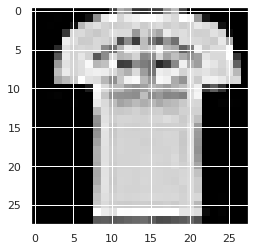

In [35]:
from keras.datasets import fashion_mnist

# Load the Fashion MNIST dataset.
(X_train_fashion, Y_train_fashion), (X_test_fashion, Y_test_fashion) = fashion_mnist.load_data()
X_train_fashion = X_train_fashion / 255.
X_test_fashion = X_test_fashion / 255.

# Flatten Y_train and Y_test, so they become vectors of label values.
Y_train_fashion = Y_train_fashion.flatten()
Y_test_fashion = Y_test_fashion.flatten()

label_names = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
               'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

# Apply random shufflying to training examples.
np.random.seed(0)
indices = np.arange(X_train_fashion.shape[0])
shuffled_indices = np.random.permutation(indices)
X_train_fashion = X_train_fashion[shuffled_indices]
Y_train_fashion = Y_train_fashion[shuffled_indices]

# Show the first training example.
print('Label: %s' %label_names[Y_train_fashion[0]])
plt.imshow(X_train_fashion[0], cmap='gray')
plt.show()

In [36]:
len(X_train_fashion), len(X_test_fashion), X_train_fashion.shape

(60000, 10000, (60000, 28, 28))

### MNIST

We also load the (digits) mnist dataset in the same way. Note that the number of train/test examples as well as the data shapes are identical to fashion_mnist.

Label: 3


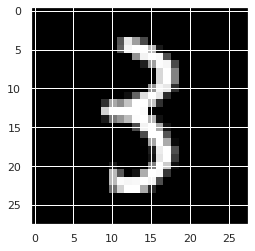

In [37]:
from keras.datasets import mnist

# Load the MNIST dataset.
(X_train_digits, Y_train_digits), (X_test_digits, Y_test_digits) = mnist.load_data()
X_train_digits = X_train_digits / 255
X_test_digits = X_test_digits / 255

# Flatten Y_train and Y_test, so they become vectors of label values.
Y_train_digits = Y_train_digits.flatten()
Y_test_digits = Y_test_digits.flatten()

# Apply random shufflying to training examples.
np.random.seed(0)
indices = np.arange(X_train_digits.shape[0])
shuffled_indices = np.random.permutation(indices)
X_train_digits = X_train_digits[shuffled_indices]
Y_train_digits = Y_train_digits[shuffled_indices]

# Show the first training example.
print('Label: %d' %Y_train_digits[0])
plt.imshow(X_train_digits[0], cmap='gray')
plt.show()

In [38]:
len(X_train_digits), len(X_test_digits), X_train_digits.shape

(60000, 10000, (60000, 28, 28))

## Build a Model

We will write a build_model function that allows for a range of experiments on both datasets.

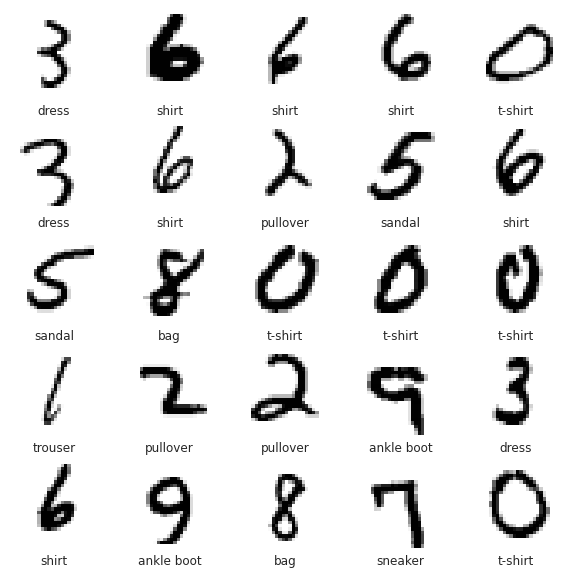

In [39]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train_digits[i], cmap=plt.cm.binary)
    plt.xlabel(label_names[Y_train_digits[i]])
plt.show()

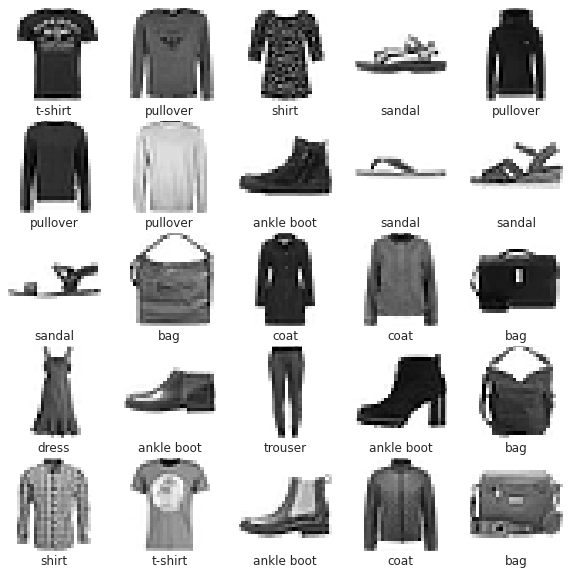

In [40]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train_fashion[i], cmap=plt.cm.binary)
    plt.xlabel(label_names[Y_train_fashion[i]])
plt.show()

---
### Exercise 1 (58points)

Fill in code that implements the build_model function, including all the arguments listed in the function definition.

In [68]:
def build_model(n_classes,
                hidden_layer_sizes=[],
                activation = 'relu',
                optimizer = 'SGD',
                learning_rate = 0.01):
  """Build a multi-class logistic regression model using Keras.

  Args:
    n_classes: Number of output classes in the dataset.
    hidden_layer_sizes: A list with the number of units in each hidden layer.
    activation: The activation function to use for the hidden layers.
    optimizer: The optimizer to use (SGD, Adam).
    learning_rate: The desired learning rate for the optimizer.

  Returns:
    model: A tf.keras model (graph).
  """
  tf.keras.backend.clear_session()
  np.random.seed(0)
  tf.random.set_seed(0)

  # YOUR CODE HERE
  layer_list = []
  # first layer: input
  input1 = tf.keras.layers.Flatten(input_shape=(28, 28))
  layer_list.append(input1)
  #Adding hidden layers
  for idx, node_cnt in enumerate(hidden_layer_sizes):
      layer_list.append(tf.keras.layers.Dense(units = node_cnt
                                            , activation = activation
                                            , name = 'fc_' + str(idx + 1)))
  
  # Adding output layer
  layer_list.append(tf.keras.layers.Dense(units = n_classes, 
                                          activation = 'softmax', 
                                          name = 'Output'))
  
  model = tf.keras.Sequential(layer_list)
  print(model.summary())
  layers = [layer.output for layer in model.layers]
  print(layers)
  trainable_count = count_params(model.trainable_weights)
  non_trainable_count = count_params(model.non_trainable_weights)
  print(f"Tainable parameters : {trainable_count}")
  print(f"Non-tainable parameters : {non_trainable_count}")
  if optimizer.upper() == 'SGD':
      optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate)
  elif optimizer.upper() == 'ADAM':
      optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
  
  model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(), 
                optimizer = optimizer, 
                metrics=['accuracy'])    
  
  return model

---

## Run Experiments

We can now run a suite of experiments to see how the hyperparameters and layer sizes effect performance. The train_and_evaluate function below can be used to run experiments and retrieve results.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 Output (Dense)              (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
None
[<KerasTensor: shape=(None, 784) dtype=float32 (created by layer 'flatten')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'Output')>]
Tainable parameters : 7850
Non-tainable parameters : 0
Training...
Epoch 1/5
844/844 [==============================] - 3s 3ms/step - loss: 2.2713 - accuracy: 0.4772 - val_loss: 2.2761 - val_accuracy: 0.5150
Epoch 2/5
844/844 [==============================] - 2s 2ms/step - loss: 2.2858 - ac

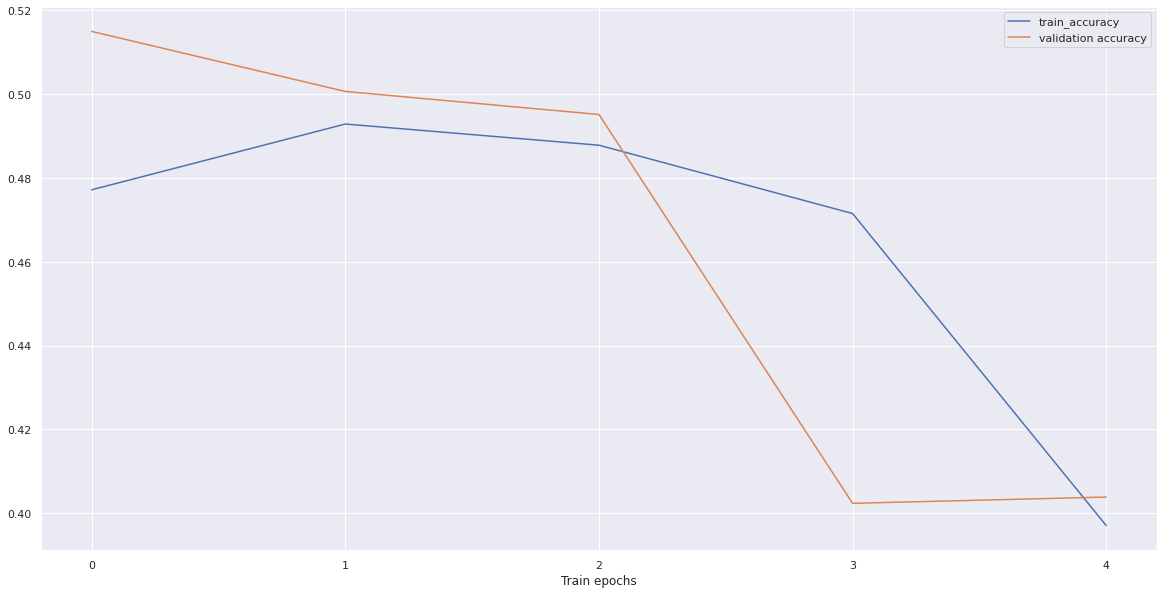

Test Accuracy: 0.4063
Total Parameters: 7850


In [67]:
def train_and_evaluate(data = 'digits',
                       hidden_layer_sizes = [],
                       activation = 'tanh',
                       optimizer = 'Adam',
                       learning_rate = 0.01,
                       num_epochs = 5):

  # Build the model.
  model = build_model(n_classes = 10,
                      hidden_layer_sizes = hidden_layer_sizes,
                      activation = activation,
                      optimizer = optimizer,
                      learning_rate = learning_rate)

  # Select the dataset.
  if data == 'digits':
    X_train = X_train_digits
    X_test = X_test_digits
    Y_train = Y_train_digits
    Y_test = Y_test_digits
  elif data == 'fashion':
    X_train = X_train_fashion
    X_test = X_test_fashion
    Y_train = Y_train_fashion
    Y_test = Y_test_fashion
  else:
    raise 'Unsupported dataset: %s' %data

  # Train the model.
  print('Training...')
  #history = model.fit(x = X_train,
  #  y = Y_train, epochs=10, validation_split = 0.1)
  
  history = model.fit(
    x = X_train,
    y = Y_train,
    epochs = num_epochs,
    batch_size = 64,
    validation_split = 0.1,
    verbose = 1)
  
  # Retrieve the training metrics (after each train epoch) and the final test
  # accuracy.
  plt.rcParams["figure.figsize"] = (20,10)
  train_accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  plt.plot(train_accuracy, label='train_accuracy')
  plt.plot(val_accuracy, label='validation accuracy')
  plt.xticks(range(num_epochs))
  plt.xlabel('Train epochs')
  plt.legend()
  plt.show()

  test_accuracy = model.evaluate(x = X_test, y = Y_test, verbose = 0,
                                 return_dict = True)['accuracy']
  total_parameters = count_params(model.trainable_weights)
  return test_accuracy, total_parameters

test_accuracy, total_parameters = train_and_evaluate()
print('Test Accuracy: %1.4f' %test_accuracy)
print('Total Parameters: %1.0f' %total_parameters)

---
### Exercise 2 (8 points)

Run experiments and fill in the test results in the table below. Feel free to extend the table to more experiments as you see fit.

*********************

Parameters used:  ['digits', [], 'tanh', 'SGD', 0.01, 5]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 Output (Dense)              (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
None
[<KerasTensor: shape=(None, 784) dtype=float32 (created by layer 'flatten')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'Output')>]
Tainable parameters : 7850
Non-tainable parameters : 0
Training...
Epoch 1/5
844/844 [==============================] - 2s 2ms/step - loss: 1.0282 - accuracy: 0.7561 - val_loss: 0.6476 - val_accuracy: 0.8513
Epoc

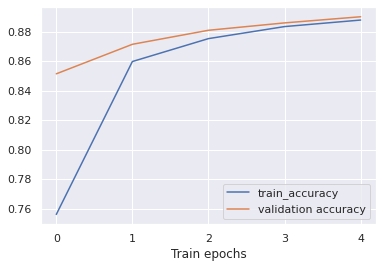

Test Accuracy: 0.8966
Total Parameters: 7850
*********************

Parameters used:  ['digits', [], 'relu', 'SGD', 0.01, 5]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 Output (Dense)              (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
None
[<KerasTensor: shape=(None, 784) dtype=float32 (created by layer 'flatten')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'Output')>]
Tainable parameters : 7850
Non-tainable parameters : 0
Training...
Epoch 1/5
844/844 [==============================] - 2s 2ms/step - loss: 1.0282 - accuracy: 0.7561 -

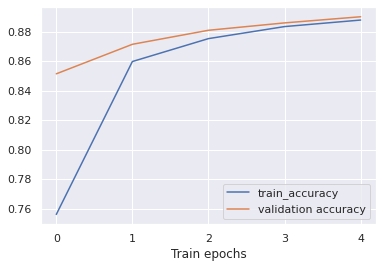

Test Accuracy: 0.8966
Total Parameters: 7850
*********************

Parameters used:  ['digits', [], 'relu', 'Adam', 0.01, 5]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 Output (Dense)              (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
None
[<KerasTensor: shape=(None, 784) dtype=float32 (created by layer 'flatten')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'Output')>]
Tainable parameters : 7850
Non-tainable parameters : 0
Training...
Epoch 1/5
844/844 [==============================] - 2s 2ms/step - loss: 0.3600 - accuracy: 0.8969 

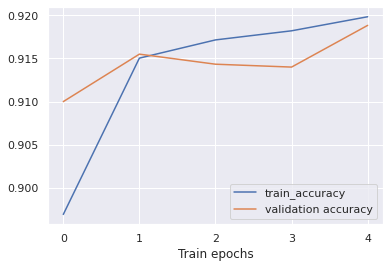

Test Accuracy: 0.9207
Total Parameters: 7850
*********************

Parameters used:  ['digits', [128], 'relu', 'Adam', 0.01, 5]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 fc_1 (Dense)                (None, 128)               100480    
                                                                 
 Output (Dense)              (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
None
[<KerasTensor: shape=(None, 784) dtype=float32 (created by layer 'flatten')>, <KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'fc_1')>, <KerasTensor: shape=(None, 1

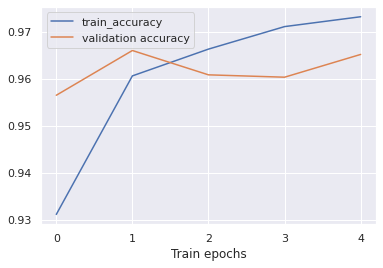

Test Accuracy: 0.9640
Total Parameters: 101770
*********************

Parameters used:  ['digits', [256, 128], 'relu', 'Adam', 0.01, 5]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 fc_1 (Dense)                (None, 256)               200960    
                                                                 
 fc_2 (Dense)                (None, 128)               32896     
                                                                 
 Output (Dense)              (None, 10)                1290      
                                                                 
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________
None
[<KerasTensor: shape=(None, 784) dtype=fl

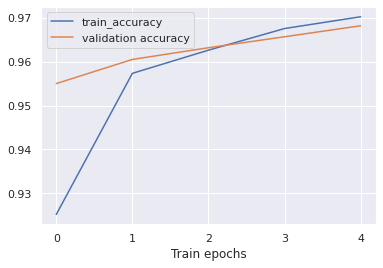

Test Accuracy: 0.9673
Total Parameters: 235146
*********************

Parameters used:  ['fashion', [], 'tanh', 'SGD', 0.01, 5]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 Output (Dense)              (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
None
[<KerasTensor: shape=(None, 784) dtype=float32 (created by layer 'flatten')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'Output')>]
Tainable parameters : 7850
Non-tainable parameters : 0
Training...
Epoch 1/5
844/844 [==============================] - 2s 2ms/step - loss: 0.9976 - accuracy: 0.694

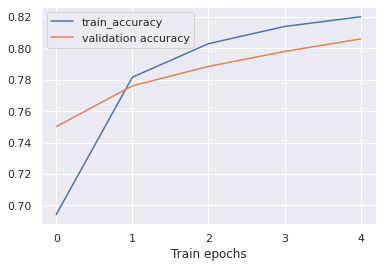

Test Accuracy: 0.8092
Total Parameters: 7850
*********************

Parameters used:  ['fashion', [], 'relu', 'SGD', 0.01, 5]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 Output (Dense)              (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
None
[<KerasTensor: shape=(None, 784) dtype=float32 (created by layer 'flatten')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'Output')>]
Tainable parameters : 7850
Non-tainable parameters : 0
Training...
Epoch 1/5
844/844 [==============================] - 2s 2ms/step - loss: 0.9976 - accuracy: 0.6943 

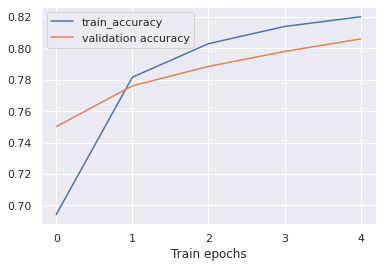

Test Accuracy: 0.8092
Total Parameters: 7850
*********************

Parameters used:  ['fashion', [], 'relu', 'Adam', 0.01, 5]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 Output (Dense)              (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
None
[<KerasTensor: shape=(None, 784) dtype=float32 (created by layer 'flatten')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'Output')>]
Tainable parameters : 7850
Non-tainable parameters : 0
Training...
Epoch 1/5
844/844 [==============================] - 2s 2ms/step - loss: 0.5593 - accuracy: 0.8102

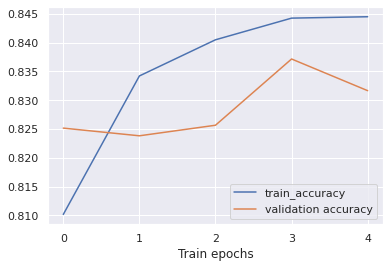

Test Accuracy: 0.8356
Total Parameters: 7850
*********************

Parameters used:  ['fashion', [128], 'relu', 'Adam', 0.01, 5]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 fc_1 (Dense)                (None, 128)               100480    
                                                                 
 Output (Dense)              (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
None
[<KerasTensor: shape=(None, 784) dtype=float32 (created by layer 'flatten')>, <KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'fc_1')>, <KerasTensor: shape=(None, 

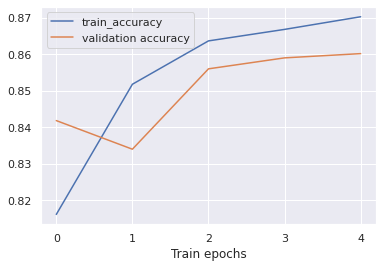

Test Accuracy: 0.8545
Total Parameters: 101770
*********************

Parameters used:  ['fashion', [256, 128], 'relu', 'Adam', 0.01, 5]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 fc_1 (Dense)                (None, 256)               200960    
                                                                 
 fc_2 (Dense)                (None, 128)               32896     
                                                                 
 Output (Dense)              (None, 10)                1290      
                                                                 
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________
None
[<KerasTensor: shape=(None, 784) dtype=f

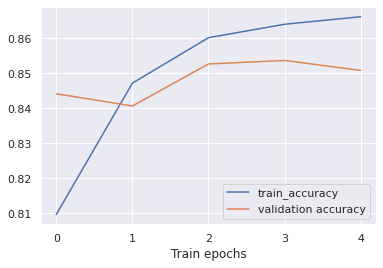

Test Accuracy: 0.8421
Total Parameters: 235146
*********************

Parameters used:  ['digits', [], 'tanh', 'SGD', 0.01, 10]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 Output (Dense)              (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
None
[<KerasTensor: shape=(None, 784) dtype=float32 (created by layer 'flatten')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'Output')>]
Tainable parameters : 7850
Non-tainable parameters : 0
Training...
Epoch 1/10
844/844 [==============================] - 2s 2ms/step - loss: 1.0282 - accuracy: 0.75

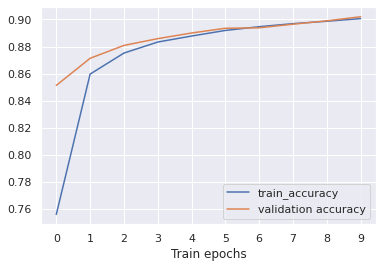

Test Accuracy: 0.9075
Total Parameters: 7850
*********************

Parameters used:  ['digits', [], 'relu', 'SGD', 0.01, 10]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 Output (Dense)              (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
None
[<KerasTensor: shape=(None, 784) dtype=float32 (created by layer 'flatten')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'Output')>]
Tainable parameters : 7850
Non-tainable parameters : 0
Training...
Epoch 1/10
844/844 [==============================] - 2s 2ms/step - loss: 1.0282 - accuracy: 0.7561

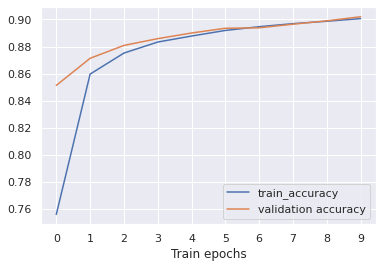

Test Accuracy: 0.9075
Total Parameters: 7850
*********************

Parameters used:  ['digits', [], 'relu', 'Adam', 0.01, 10]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 Output (Dense)              (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
None
[<KerasTensor: shape=(None, 784) dtype=float32 (created by layer 'flatten')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'Output')>]
Tainable parameters : 7850
Non-tainable parameters : 0
Training...
Epoch 1/10
844/844 [==============================] - 3s 3ms/step - loss: 0.3600 - accuracy: 0.896

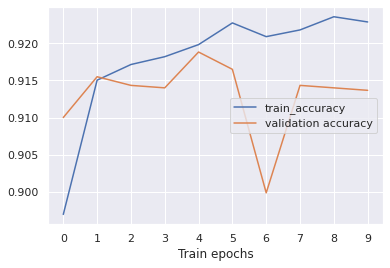

Test Accuracy: 0.9209
Total Parameters: 7850
*********************

Parameters used:  ['digits', [128], 'relu', 'Adam', 0.01, 10]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 fc_1 (Dense)                (None, 128)               100480    
                                                                 
 Output (Dense)              (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
None
[<KerasTensor: shape=(None, 784) dtype=float32 (created by layer 'flatten')>, <KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'fc_1')>, <KerasTensor: shape=(None, 

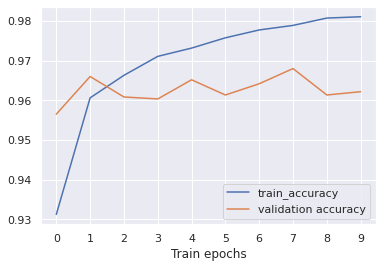

Test Accuracy: 0.9623
Total Parameters: 101770
*********************

Parameters used:  ['digits', [256, 128], 'relu', 'Adam', 0.01, 10]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 fc_1 (Dense)                (None, 256)               200960    
                                                                 
 fc_2 (Dense)                (None, 128)               32896     
                                                                 
 Output (Dense)              (None, 10)                1290      
                                                                 
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________
None
[<KerasTensor: shape=(None, 784) dtype=f

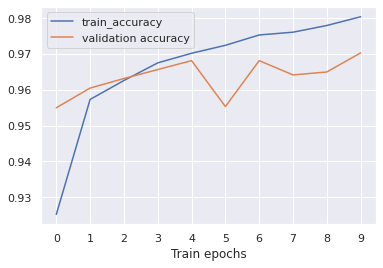

Test Accuracy: 0.9711
Total Parameters: 235146
*********************

Parameters used:  ['fashion', [], 'tanh', 'SGD', 0.01, 10]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 Output (Dense)              (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
None
[<KerasTensor: shape=(None, 784) dtype=float32 (created by layer 'flatten')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'Output')>]
Tainable parameters : 7850
Non-tainable parameters : 0
Training...
Epoch 1/10
844/844 [==============================] - 2s 2ms/step - loss: 0.9976 - accuracy: 0.6

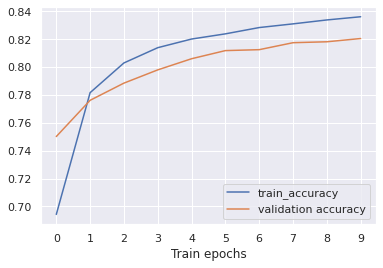

Test Accuracy: 0.8232
Total Parameters: 7850
*********************

Parameters used:  ['fashion', [], 'relu', 'SGD', 0.01, 10]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 Output (Dense)              (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
None
[<KerasTensor: shape=(None, 784) dtype=float32 (created by layer 'flatten')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'Output')>]
Tainable parameters : 7850
Non-tainable parameters : 0
Training...
Epoch 1/10
844/844 [==============================] - 2s 2ms/step - loss: 0.9976 - accuracy: 0.694

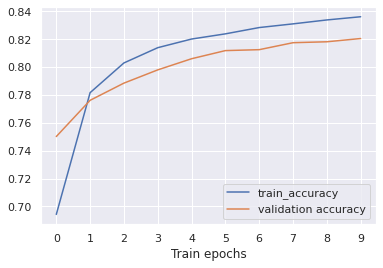

Test Accuracy: 0.8232
Total Parameters: 7850
*********************

Parameters used:  ['fashion', [], 'relu', 'Adam', 0.01, 10]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 Output (Dense)              (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
None
[<KerasTensor: shape=(None, 784) dtype=float32 (created by layer 'flatten')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'Output')>]
Tainable parameters : 7850
Non-tainable parameters : 0
Training...
Epoch 1/10
844/844 [==============================] - 3s 3ms/step - loss: 0.5593 - accuracy: 0.81

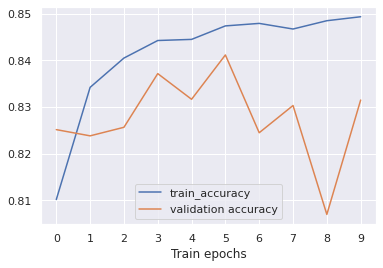

Test Accuracy: 0.8292
Total Parameters: 7850
*********************

Parameters used:  ['fashion', [128], 'relu', 'Adam', 0.01, 10]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 fc_1 (Dense)                (None, 128)               100480    
                                                                 
 Output (Dense)              (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
None
[<KerasTensor: shape=(None, 784) dtype=float32 (created by layer 'flatten')>, <KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'fc_1')>, <KerasTensor: shape=(None,

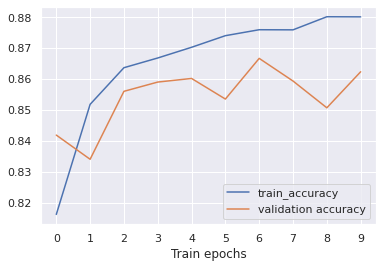

Test Accuracy: 0.8622
Total Parameters: 101770
*********************

Parameters used:  ['fashion', [256, 128], 'relu', 'Adam', 0.01, 10]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 fc_1 (Dense)                (None, 256)               200960    
                                                                 
 fc_2 (Dense)                (None, 128)               32896     
                                                                 
 Output (Dense)              (None, 10)                1290      
                                                                 
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________
None
[<KerasTensor: shape=(None, 784) dtype=

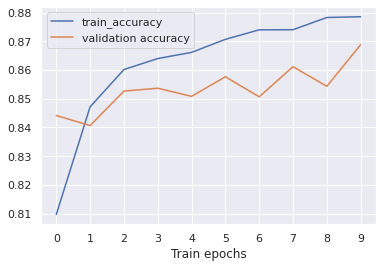

Test Accuracy: 0.8643
Total Parameters: 235146
*********************

Parameters used:  ['fashion', [128], 'softmax', 'Adam', 0.01, 10]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 fc_1 (Dense)                (None, 128)               100480    
                                                                 
 Output (Dense)              (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
None
[<KerasTensor: shape=(None, 784) dtype=float32 (created by layer 'flatten')>, <KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'fc_1')>, <KerasTensor: shape=(

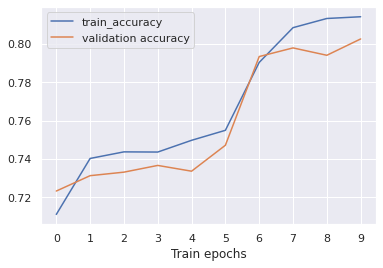

Test Accuracy: 0.8057
Total Parameters: 101770
*********************

Parameters used:  ['fashion', [], 'softmax', 'SGD', 0.01, 10]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 Output (Dense)              (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
None
[<KerasTensor: shape=(None, 784) dtype=float32 (created by layer 'flatten')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'Output')>]
Tainable parameters : 7850
Non-tainable parameters : 0
Training...
Epoch 1/10
844/844 [==============================] - 3s 3ms/step - loss: 0.9976 - accuracy: 

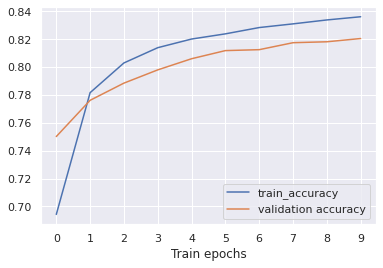

Test Accuracy: 0.8232
Total Parameters: 7850
(['digits', [], 'tanh', 'SGD', 0.01, 5], 7850, 0.8966000080108643)
(['digits', [], 'relu', 'SGD', 0.01, 5], 7850, 0.8966000080108643)
(['digits', [], 'relu', 'Adam', 0.01, 5], 7850, 0.9207000136375427)
(['digits', [128], 'relu', 'Adam', 0.01, 5], 101770, 0.9639999866485596)
(['digits', [256, 128], 'relu', 'Adam', 0.01, 5], 235146, 0.9672999978065491)
(['fashion', [], 'tanh', 'SGD', 0.01, 5], 7850, 0.8091999888420105)
(['fashion', [], 'relu', 'SGD', 0.01, 5], 7850, 0.8091999888420105)
(['fashion', [], 'relu', 'Adam', 0.01, 5], 7850, 0.8356000185012817)
(['fashion', [128], 'relu', 'Adam', 0.01, 5], 101770, 0.8544999957084656)
(['fashion', [256, 128], 'relu', 'Adam', 0.01, 5], 235146, 0.8421000242233276)
(['digits', [], 'tanh', 'SGD', 0.01, 10], 7850, 0.9075000286102295)
(['digits', [], 'relu', 'SGD', 0.01, 10], 7850, 0.9075000286102295)
(['digits', [], 'relu', 'Adam', 0.01, 10], 7850, 0.9208999872207642)
(['digits', [128], 'relu', 'Adam', 0.01

In [48]:
param_list = [
['digits',[],'tanh','SGD',0.01, 5],
['digits',[],'relu','SGD',0.01, 5],
['digits',[],'relu','Adam',0.01, 5],
['digits',[128],'relu','Adam',0.01, 5],
['digits',[256,128],'relu','Adam',0.01, 5],

['fashion',[],'tanh','SGD',0.01, 5],
['fashion',[],'relu','SGD',0.01, 5],
['fashion',[],'relu','Adam',0.01, 5],
['fashion',[128],'relu','Adam',0.01, 5],
['fashion',[256,128],'relu','Adam',0.01, 5],

### My Addition ###
['digits',[],'tanh','SGD',0.01, 10],
['digits',[],'relu','SGD',0.01, 10],
['digits',[],'relu','Adam',0.01, 10],
['digits',[128],'relu','Adam',0.01, 10],
['digits',[256,128],'relu','Adam',0.01, 10],

['fashion',[],'tanh','SGD',0.01, 10],
['fashion',[],'relu','SGD',0.01, 10],
['fashion',[],'relu','Adam',0.01, 10],
['fashion',[128],'relu','Adam',0.01, 10],
['fashion',[256,128],'relu','Adam',0.01, 10],
['fashion',[128],'softmax','Adam',0.01, 10],
['fashion',[],'softmax','SGD',0.01, 10]
]

output_list = []
for param in param_list:
    print("*********************")
    print()
    print("Parameters used: ",param)
    test_accuracy, total_parameters = train_and_evaluate(data = param[0],
                                                     hidden_layer_sizes = param[1],
                                                     activation = param[2],
                                                     optimizer = param[3],
                                                     learning_rate = param[4],
                                                     num_epochs = param[5] 
                                                    )
    print('Test Accuracy: %1.4f' %test_accuracy)
    print('Total Parameters: %1.0f' %total_parameters)
    output_list.append((param, total_parameters, test_accuracy))

for e in output_list:
    print(e)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 fc_1 (Dense)                (None, 256)               200960    
                                                                 
 Output (Dense)              (None, 10)                2570      
                                                                 
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________
None
[<KerasTensor: shape=(None, 784) dtype=float32 (created by layer 'flatten')>, <KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'fc_1')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'Output')>]
Tainable parameters : 203530
Non-tainable parameters : 0
Training...
Epoch 1/10
84

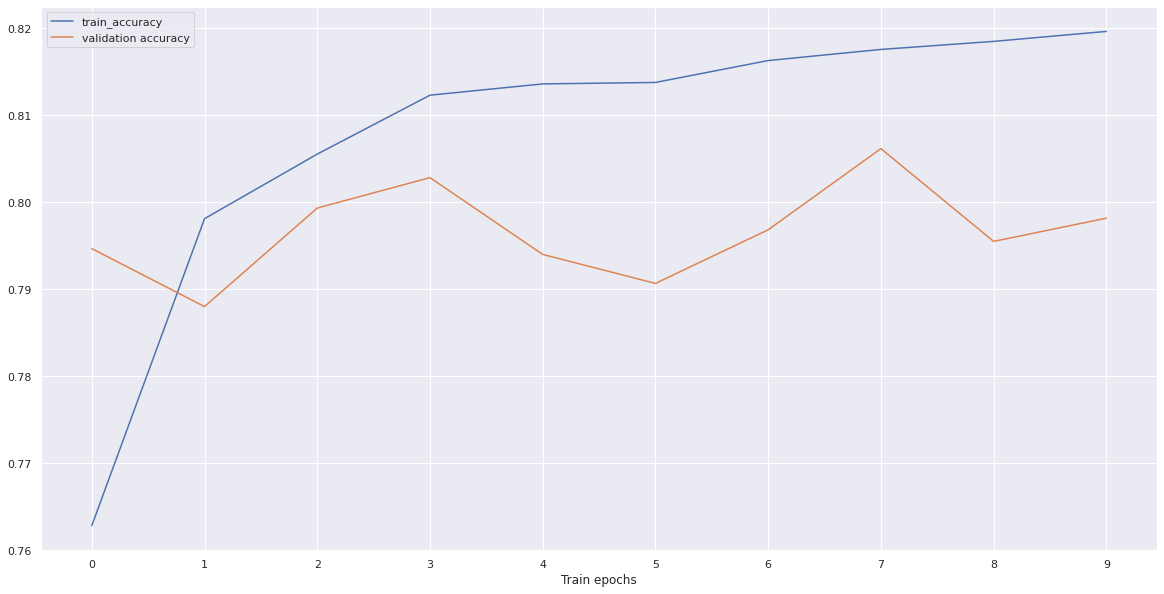

(0.7989000082015991, 203530)

In [64]:
train_and_evaluate(data = 'fashion',
                                                     hidden_layer_sizes = [256],
                                                     activation = 'softmax',
                                                     optimizer = 'adam',
                                                     learning_rate = .01,
                                                     num_epochs = 10
                                                    )

#### Student Solution

DATA | HIDDEN SIZES | ACTIVATION | OPTIMIZER | LEARNING RATE | #PARAMETERS | TEST ACCURACY
-|-|-|-|-|-|-
digits|[]|tanh|SGD|0.01|7850|0.8966000080108643
digits|[]|relu|SGD|0.01|7850|0.8966000080108643
digits|[]|relu|Adam|0.01|7850|0.9207000136375427
digits|[128]|relu|Adam|0.01|101770|0.9639999866485596
digits|[256,128]|relu|Adam|0.01|235146|0.9672999978065491
-
fashion|[]|tanh|SGD|0.01|7850|0.8091999888420105
fashion|[]|relu|SGD|0.01|7850|0.8091999888420105
fashion|[]|relu|Adam|0.01|7850|0.8356000185012817
fashion|[128]|relu|Adam|0.01|101770|0.8544999957084656
fashion|[256,128]|relu|Adam|0.01|235146|0.8421000242233276
